# Feature selection

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import afdetection.utils.paths as path

from afdetection.data.make_dataset import MakeDataset
from afdetection.features.build_features import BuildFeatures

from xgboost import XGBClassifier
from sklearn_genetic import GAFeatureSelectionCV

## Load dataset file

In [18]:
# make_data = MakeDataset()
# dataset_DIR = path.data_raw_dir('dataset.csv')
# dataset = make_data.read_from_csv(dataset_DIR)

# build_features = BuildFeatures()
# X, y = build_features.features_target_split(
#     dataset=dataset,
#     drop_cols=['diagnosi', 'ritmi'],
#     target='ritmi'
# )

## Load wavelet fatures

In [19]:
make_data = MakeDataset()
wavelet_features_DIR = path.data_raw_dir('ecg_features_wavelet.csv')
wavelet_features = make_data.read_from_csv(wavelet_features_DIR)

# Get only 1 derivation
wavelet_features = wavelet_features.iloc[:, :6]

target_DIR = path.data_raw_dir('coorteeqsrafva.csv')
target = make_data.read_from_csv(target_DIR, sep=';')
target = target['ritmi']

dataset = pd.concat([wavelet_features, target], axis=1)
display(dataset)

build_features = BuildFeatures()
X, y = build_features.features_target_split(
    dataset=dataset,
    drop_cols=['ritmi'],
    target='ritmi'
)

,I_cA5_energy,I_cD5_energy,I_cD4_energy,I_cD3_energy,I_cD2_energy,I_cD1_energy,ritmi
0,55.013139,96.480633,121.504127,13.488700,0.591159,0.111367,VA
1,55.013139,96.480633,121.504127,13.488700,0.591159,0.111367,AF
2,41.573709,20.138983,7.832812,0.944590,0.082381,0.033544,SR
3,61.783369,51.065864,53.527336,11.363368,1.552001,0.406809,VA
4,23.353338,13.608418,4.542217,0.980550,0.189123,0.044602,VA
...,...,...,...,...,...,...,...
6423,8.502504,2.768978,2.274819,0.378829,0.067696,0.023346,VA
6424,51.284600,9.643762,3.406913,0.625492,0.209773,0.064470,VA
6425,11.661859,5.792339,3.894952,2.313951,1.974222,0.757749,SR
6426,15.923179,8.861932,3.909852,1.520737,0.447607,0.113704,AF


## Correlation analysis


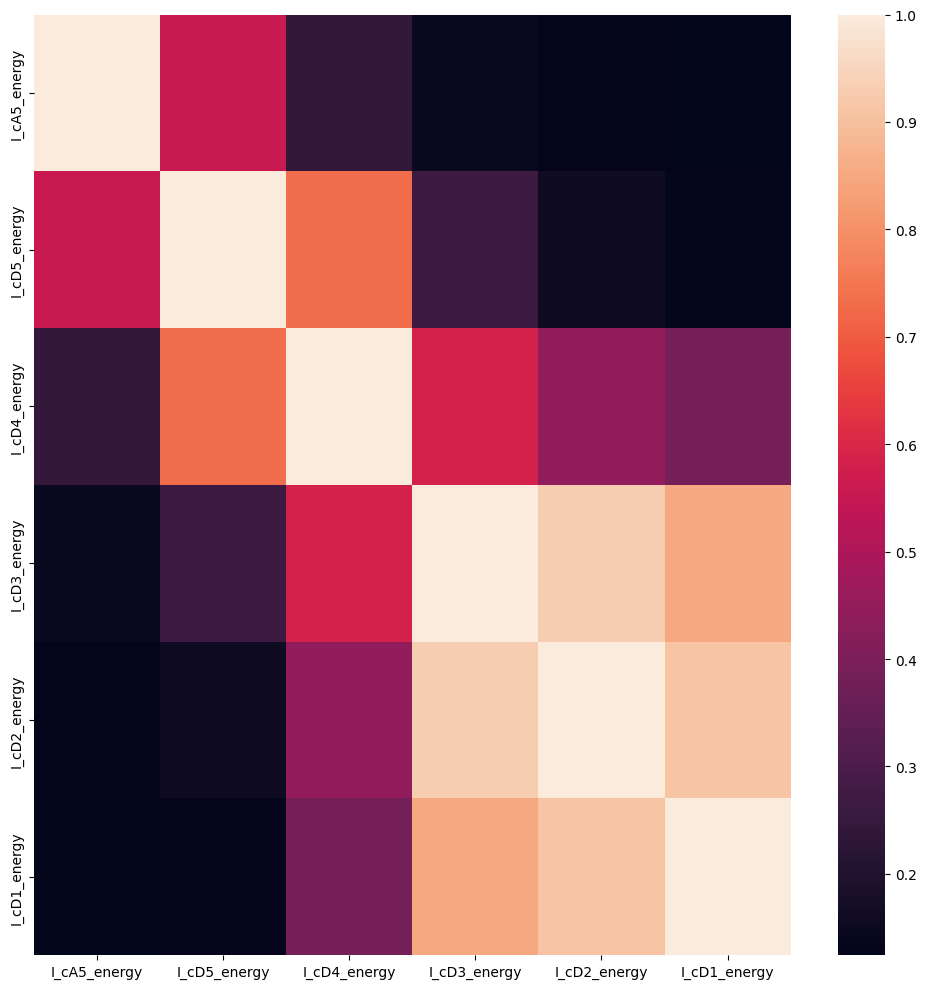

In [20]:
corr = X.corr().abs()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=False)
plt.tight_layout()
plt.show()

In [21]:
thr = 0.7 # Correlation threshold
support = np.full((corr.shape[0]), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= thr:
            if support[j]:
                support[j] = False

selected_corr = X.columns[support].to_list()
discarted_corr = X.columns[~support].to_list()

print('Independent features:\n', selected_corr)
print('Dependent features:\n', discarted_corr)

Independent features:
 ['I_cA5_energy', 'I_cD5_energy', 'I_cD3_energy']
Dependent features:
 ['I_cD4_energy', 'I_cD2_energy', 'I_cD1_energy']


## Genetic algorithm feature selection

In [24]:
# Estimator
clf = XGBClassifier()

selector = GAFeatureSelectionCV(estimator=clf,
                                cv=2,
                                scoring="accuracy",
                                population_size=10,
                                generations=5,
                                max_features=3,
                                n_jobs=-1,
                                verbose=True,
                                keep_top_k=1,
                                elitism=True)

selector.fit(X, y)
support = selector.best_features_

selected_ga = X.columns[support].to_list()
discarted_ga = X.columns[~support].to_list()

print('Selected features:\n', selected_ga)
print('Discarted features:\n', discarted_ga)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	-29999.7	45825.9    	0.400591   	-100000    
1  	20    	-39999.8	48990      	0.398258   	-100000    
2  	20    	-19999.7	40000.2    	0.398258   	-100000    
3  	20    	-19999.7	40000.2    	0.398258   	-100000    
4  	20    	0.396266	0.00398258 	0.398258   	0.388301   
5  	20    	-19999.7	40000.2    	0.398258   	-100000    
Selected features:
 ['I_cA5_energy', 'I_cD3_energy']
Discarted features:
 ['I_cD5_energy', 'I_cD4_energy', 'I_cD2_energy', 'I_cD1_energy']


In [23]:
# Selected features: V0
['I_cD1_energy', 'I_cD4_mean', 'I_cD3_mean', 'I_cD2_mean', 'I_cA5_varance', 'I_cD5_varance', 'I_cD4_varance', 'I_cD1_varance', 'I_cD5_std_dev', 'I_cD4_std_dev', 'I_cD3_std_dev', 'II_cA5_energy', 'II_cD5_energy', 'II_cD2_energy', 'II_cD4_mean', 'II_cD3_mean', 'II_cD2_mean', 'II_cA5_varance', 'II_cD3_varance', 'II_cD1_varance', 'II_cD5_std_dev', 'II_cD4_std_dev', 'II_cD2_std_dev', 'III_cA5_energy', 'III_cD1_energy', 'III_cD5_mean', 'III_cD4_mean', 'III_cD5_varance', 'III_cD2_varance', 'III_cD5_std_dev', 'aVF_cA5_energy', 'aVF_cD5_energy', 'aVF_cD4_energy', 'aVF_cD1_energy', 'aVF_cA5_mean', 'aVF_cD4_mean', 'aVF_cD3_mean', 'aVF_cD1_mean', 'aVF_cD3_varance', 'aVF_cD1_varance', 'aVF_cD5_std_dev', 'aVF_cD3_std_dev', 'aVF_cD2_std_dev', 'aVR_cA5_energy', 'aVR_cD5_energy', 'aVR_cD3_energy', 'aVR_cA5_mean', 'aVR_cD4_mean', 'aVR_cD3_mean', 'aVR_cD2_mean', 'aVR_cD3_varance', 'aVR_cD1_varance', 'aVR_cD5_std_dev', 'aVR_cD4_std_dev', 'aVR_cD2_std_dev', 'aVR_cD1_std_dev', 'aVL_cA5_energy', 'aVL_cD2_energy', 'aVL_cA5_mean', 'aVL_cD4_mean', 'aVL_cD3_mean', 'aVL_cD1_mean', 'aVL_cD3_std_dev', 'aVL_cD1_std_dev', 'V1_cA5_energy', 'V1_cD3_energy', 'V1_cD1_energy', 'V1_cA5_mean', 'V1_cD5_mean', 'V1_cD3_mean', 'V1_cD4_varance', 'V1_cD2_varance', 'V1_cD1_varance', 'V1_cD5_std_dev', 'V1_cD3_std_dev', 'V1_cD1_std_dev', 'V2_cD4_energy', 'V2_cD3_energy', 'V2_cD2_energy', 'V2_cD1_energy', 'V2_cA5_mean', 'V2_cD4_mean', 'V2_cD3_mean', 'V2_cD1_mean', 'V2_cA5_varance', 'V2_cD4_varance', 'V2_cD1_varance', 'V2_cD5_std_dev', 'V2_cD4_std_dev', 'V2_cD3_std_dev', 'V2_cD2_std_dev', 'V3_cD5_energy', 'V3_cD4_energy', 'V3_cD3_energy', 'V3_cD1_energy', 'V3_cD4_mean', 'V3_cD3_mean', 'V3_cD1_mean', 'V3_cD4_varance', 'V3_cD3_varance', 'V3_cD3_std_dev', 'V4_cA5_energy', 'V4_cD5_energy', 'V4_cD1_energy', 'V4_cA5_mean', 'V4_cD3_mean', 'V4_cD2_mean', 'V4_cD1_mean', 'V4_cA5_varance', 'V4_cD5_varance', 'V4_cD3_varance', 'V4_cD2_varance', 'V4_cD1_std_dev', 'V5_cD3_energy', 'V5_cD1_energy', 'V5_cD5_mean', 'V5_cD4_mean', 'V5_cD2_mean', 'V5_cD5_varance', 'V5_cD4_varance', 'V5_cD2_varance', 'V5_cD5_std_dev', 'V5_cD4_std_dev', 'V5_cD3_std_dev', 'V6_cA5_energy', 'V6_cD3_energy', 'V6_cD4_mean', 'V6_cD1_mean', 'V6_cA5_varance', 'V6_cD4_varance', 'V6_cD2_varance', 'V6_cD1_varance', 'V6_cD5_std_dev', 'V6_cD4_std_dev', 'V6_cD3_std_dev', 'V6_cD2_std_dev', 'V6_cD1_std_dev', 'aVL_dFreq', 'V1_dFreq', 'V2_dFreq', 'V4_dFreq', 'I_specEn', 'II_specEn', 'III_specEn', 'aVR_specEn', 'V1_specEn', 'V2_specEn', 'V6_specEn', 'age', 'weight']

# Selected features: V1 (just lead I)
['I_cD4_energy', 'I_cD1_energy', 'I_cA5_mean', 'I_cD5_mean', 'I_cD4_mean', 'I_cD3_mean', 'I_cD2_mean', 'I_cA5_varance', 'I_cD5_varance', 'I_cD2_varance', 'I_cD1_varance', 'I_cA5_std_dev', 'I_cD4_std_dev', 'I_cD3_std_dev', 'I_cD2_std_dev', 'I_cD1_std_dev']

# Selected features: V2 (correlation)
['I_cA5_energy', 'I_cD5_energy', 'I_cD3_energy', 'I_cA5_mean', 'I_cD5_mean', 'I_cD4_mean', 'I_cD3_mean', 'I_cD2_mean', 'I_cD1_mean']




['I_cA5_energy',
 'I_cD5_energy',
 'I_cD3_energy',
 'I_cA5_mean',
 'I_cD5_mean',
 'I_cD4_mean',
 'I_cD3_mean',
 'I_cD2_mean',
 'I_cD1_mean']